In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import html
from collections import Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_row', 10)
df = pd.read_csv('../website_classification.csv')
df.tail(10)

,website_url,cleaned_website_text,Category
1047,http://s6etue47chjq5j6ztavq7rtwgosw7qfal5vy3pf...,cheap hardcore cheap whores homedownload we ho...,Adult
1048,http://skycashbip7oxeut43aj2f62mikb3rsdua2ia2g...,skycash purchase paypal account paypal transfe...,Financial Crime
1049,http://blackzghghndv54l43hbu2mhwskwtqebdk2fudu...,black market activities marketplace buy fullz ...,Marketplace
1050,http://sentimental.o2ok2mpxd57stlhjjiu54owarb7...,leggings and ankle boots polar lights polly on...,Adult
1051,http://sk7u26ufvco3cbwhnpt2igbfunt3eovsktptmye...,devochki ls magazin big onions pedo tags cloud...,Adult
1052,http://bilinmiyor.anonblogd4pcarck2ff6qlseyawj...,undermarket undermarket buy zero day exploit d...,Marketplace
1053,http://34vs22wmxqrh7hcseld7hreku5jtghkvvnmhxyw...,buy devil s breath scopolamine how to buy scop...,Narcotics
1054,http://anony3cdmhq2c4kv2wnknfjgq7rhomy4arywktj...,anonymous marketplace best onion market anonym...,Marketplace
1055,http://c7fhkjr2zifyhrxpwvi2wvwkvtldwhfpr6xevux...,carding cc ccs buy cloned cards credit cards d...,Financial Crime
1056,http://weedstcjxcvw6qmdvjfjw65wfpl5jv255by7qjz...,products strongweed store home public pgp key ...,Narcotics


In [4]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os


class ScrapTool:   
    def visit_url(self,website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #Set up Selenium webdriver
        PATH = 'C:/Users/User01/Downloads/chromedriver_win32/chromedriver.exe'

        # Set the Chrome webdriver options
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        # Initialize the Chrome webdriver and pass the Chrome options
        service = Service(PATH)
        driver = webdriver.Chrome(service = service, options = chrome_options)

        #Load website
        driver.get(website_url)
        
        # Check if the cookie consent button is present
        cookie_button = None
        try:
            cookie_button = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "cookie-consent-button")))
        except:
            pass

        # Handle cookies if the button is present
        if cookie_button:
            cookie_button.click()

        # Extract HTML content
        html_content = driver.page_source
        driver.quit()

        soup = BeautifulSoup(html_content,'lxml')
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                    self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(string=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

In [5]:
stop_words = []
stop_words.extend(["decemeber","dec","january","jan","feb","february","march","mar","may","april","apr","june","jun","july","jul","august","aug","september","sept","oct","october","nov","november",
                   "one","two","three","hundred","thousand","million","billion","today","tomorow","week","month","year","sign in","login","sign up"])

stop_words.extend(['afghanistan', 'albania', 'algeria', 'andorra', 'angola', 'antigua', 'argentina', 'armenia', 'australia',
    'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize',
    'benin', 'bhutan', 'bolivia', 'bosnia', 'botswana', 'brazil', 'brunei', 'bulgaria', 'burkina', 'burundi',
    'cambodia', 'cameroon', 'canada', 'cape', 'central', 'chad', 'chile', 'china', 'colombia', 'comoros',
    'congo', 'costa', 'croatia', 'cuba', 'cyprus', 'czech', 'denmark', 'djibouti', 'dominica', 'dominican',
    'east', 'ecuador', 'egypt', 'el', 'equatorial', 'eritrea', 'estonia', 'ethiopia', 'fiji', 'finland',
    'france', 'gabon', 'gambia', 'georgia', 'germany', 'ghana', 'greece', 'grenada', 'guatemala', 'guinea',
    'guyana', 'haiti', 'honduras', 'hungary', 'iceland', 'india', 'indonesia', 'iran', 'iraq', 'ireland',
    'israel', 'italy', 'jamaica', 'japan', 'jordan', 'kazakhstan', 'kenya', 'kiribati', 'korea', 'kosovo',
    'kuwait', 'kyrgyzstan', 'laos', 'latvia', 'lebanon', 'lesotho', 'liberia', 'libya', 'liechtenstein',
    'lithuania', 'luxembourg', 'macedonia', 'madagascar', 'malawi', 'malaysia', 'maldives', 'mali', 'malta',
    'marshall', 'mauritania', 'mauritius', 'mexico', 'micronesia', 'moldova', 'monaco', 'mongolia', 'montenegro',
    'morocco', 'mozambique', 'myanmar', 'namibia', 'nauru', 'nepal', 'netherlands', 'new', 'nicaragua',
    'niger', 'nigeria', 'norway', 'oman', 'pakistan', 'palau', 'panama', 'papua', 'paraguay', 'peru',
    'philippines', 'poland', 'portugal', 'qatar', 'romania', 'russia', 'rwanda', 'samoa', 'san', 'sao',
    'senegal', 'serbia', 'seychelles', 'sierra', 'singapore', 'slovakia', 'slovenia', 'solomon', 'somalia',
    'south', 'spain', 'sri', 'st.', 'sudan', 'suriname', 'swaziland', 'sweden', 'switzerland', 'syria',
    'taiwan', 'tajikistan', 'tanzania', 'thailand', 'timor-leste', 'togo', 'tonga', 'trinidad', 'tunisia',
    'turkey', 'turkmenistan', 'tuvalu', 'uganda', 'ukraine', 'united', 'uruguay', 'uzbekistan', 'vanuatu',
    'vatican', 'venezuela', 'vietnam', 'yemen', 'zambia', 'zimbabwe'])

stop_words.extend([
    'dollar', 'euro', 'pound', 'rupee', 'yen', 'yuan', 'won', 'franc', 'dinar', 'peso', 'lira', 'rupee', 'ruble',
    'koruna', 'baht', 'real', 'zloty', 'rand', 'shekel', 'krona', 'dirham', 'forint', 'colón', 'hryvnia',
    'leu', 'ringgit', 'kuna', 'lempira', 'cordoba', 'kwacha', 'taka', 'quetzal', 'birr', 'rial', 'tenge',
    'shilling', 'kwacha', 'naira', 'rial', 'dinar', 'rupiah', 'pula', 'riyal', 'dinar', 'lilangeni', 'krona',
    'franc', 'syli', 'peso', 'shilling', 'baht', 'vatu', 'bolivar', 'dong', 'rial'
])

In [6]:
def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'_+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = text.split()
    tokens = [token for token in tokens if not token.isdigit()]
    cleaned_text = ' '.join(tokens)
    tokens = cleaned_text.split()
    tokens = [token for token in tokens if token not in stop_words]
    cleaned_text = " ".join(tokens)
    return cleaned_text

In [7]:
from darkwebScrapper import Scraper
def content_generation(website,dark_web):
    try:
        # scrapTool = ScrapTool()
        # web = scrapTool.visit_url(website)
        # text = cleaning_text(web['website_text'])
        web = Scraper(website,dark_web)
        text = cleaning_text(web)
        return text
    except Exception as e:
        print('Error: ',website)
        print(e)
        return None

In [56]:
websites = [
    ("http://hjvn22s2odhntwoakerjnimakfpt73owhmmp6ew6apthwrkvl4eyrlqd.onion/",True,"Narcotics"),
    ("http://m16.espykp4bdrl7cuxfrwzbxpfowck5t5t4hlbbf7zkh4hdtwbgnq2igbyd.onion/",True,"Adult"),
    ("http://ezze4txwif2yfymict7p53zxzjclgaivk5zxtfsj6mrwivn5coerw3yd.onion/",True,"Adult"),
]

for website in websites:
    try:
        content = content_generation(website[0],website[1])
        print(content)
        # content_list = [website[0],content,website[2]]
        # df.loc[len(df)] = content_list
    except Exception as e:
        print(website,": ",e)


Getting... http://hjvn22s2odhntwoakerjnimakfpt73owhmmp6ew6apthwrkvl4eyrlqd.onion/
Error:  http://hjvn22s2odhntwoakerjnimakfpt73owhmmp6ew6apthwrkvl4eyrlqd.onion/
SOCKSHTTPConnectionPool(host='hjvn22s2odhntwoakerjnimakfpt73owhmmp6ew6apthwrkvl4eyrlqd.onion', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.contrib.socks.SOCKSConnection object at 0x000001969E0A7310>: Failed to establish a new connection: 0x04: Host unreachable'))
None
Getting... http://m16.espykp4bdrl7cuxfrwzbxpfowck5t5t4hlbbf7zkh4hdtwbgnq2igbyd.onion/
Error:  http://m16.espykp4bdrl7cuxfrwzbxpfowck5t5t4hlbbf7zkh4hdtwbgnq2igbyd.onion/
SOCKSHTTPConnectionPool(host='m16.espykp4bdrl7cuxfrwzbxpfowck5t5t4hlbbf7zkh4hdtwbgnq2igbyd.onion', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.contrib.socks.SOCKSConnection object at 0x000001969DE6FF10>: Failed to establish a new connection: 0x04: Host unreachable'))
None
Getting... http://ezze4txwif2yfymict7p53zxzjclgaiv

In [8]:
df['Category'].value_counts()

Computers and Technology           302
Social Networking and Messaging    114
Marketplace                        114
Business/Corporate                 106
News                                93
                                  ... 
Law and Government                  83
Adult                               58
Financial Crime                     51
Intelligence                        34
Forums                              16
Name: Category, Length: 11, dtype: int64

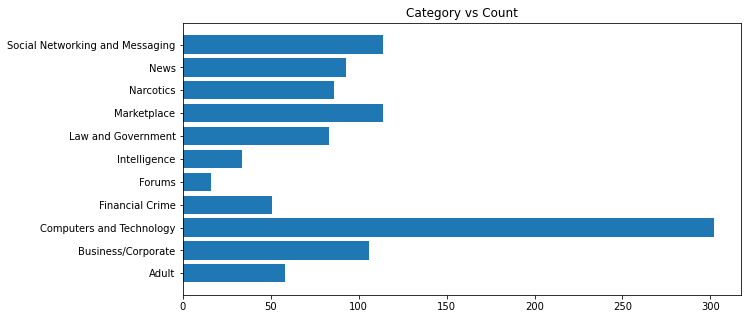

In [9]:
#visualising the count of each category
plt.figure(figsize=(10,5))
plt.title("Category vs Count")
site_category_count = pd.DataFrame(df.groupby(df['Category']).size(),columns=['Count'])
plt.barh(width=site_category_count['Count'],y=site_category_count.index)
plt.show()

In [54]:
df.drop(df.loc[(df["cleaned_website_text"].isnull())]["website_url"].index,inplace=True)

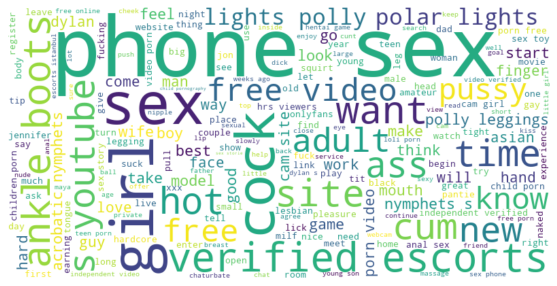

In [55]:
from wordcloud import WordCloud

category_name = "Adult"
category_data = df[df["Category"]==category_name]['cleaned_website_text']
category_text = ' '.join(category_data)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

important_words = wordcloud.words_.keys()


In [12]:
df.drop([1000],inplace=True)

In [13]:
df.reset_index(drop=True, inplace=True)

In [14]:
df.to_csv("website_classification.csv",index=False)
# computers.to_csv("../Hierarchal model/Computer/computer_subcategory_classification.csv",index=False)